In [200]:
# Team 3
# Anirban Mukherjee
# Manjusha Chava
# Tae Hyun Je  
# 11/11/2020

In [201]:
import numpy as np
import matplotlib.pyplot as plt
from commpy.filters import rcosfilter, rrcosfilter
import scipy.interpolate
import math
import scipy.signal

In [202]:
# Define plotting parameters
pxoffset = 1
pyoffset = 1
pwidth = 7
pheight = 4
smalltxtsize = 12
medtxtsize = 14
bigtxtsize = 18

plt.rc('font', size=smalltxtsize)          # controls default text sizes
plt.rc('axes', titlesize=smalltxtsize)     # fontsize of the axes title
plt.rc('axes', labelsize=medtxtsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=smalltxtsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smalltxtsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=smalltxtsize)    # legend fontsize
plt.rc('figure', titlesize=bigtxtsize)  # fontsize of the figure title

In [203]:
# Equivalent implementation of MATLAB's interp function
def interpolate_1d_vector(vector, factor):
    """
    Interpolate, i.e. upsample, a given 1D vector by a specific interpolation factor.
    :param vector: 1D data vector
    :param factor: factor for interpolation (must be integer)
    :return: interpolated 1D vector by a given factor
    """
    x = np.arange(np.size(vector))
    y = vector
    f = scipy.interpolate.interp1d(x, y, kind='cubic')

    x_extended_by_factor = np.linspace(x[0], x[-1], np.size(x) * factor)
    y_interpolated = np.zeros(np.size(x_extended_by_factor))

    i = 0
    for x in x_extended_by_factor:
        y_interpolated[i] = f(x)
        i += 1

    return y_interpolated

In [204]:
# Define simulation parameters to be used in Section 2 and Section 3
N_bits = 10000 # Total number of bits for entire transmission
f_c = 2        # Carrier frequency
f_s = 10       # Sampling frequency
f_d = 1        # Digital system sampling frequency
beta = 0.5     # Roll-off factor for raised cosine filter
sigma_n = 0.25 # Noise standard deviation

In [205]:
# Generate random binary data stream
bin_data = np.around(np.random.random((N_bits,)))

# Assignment of binary sets to amplitude values
bin1 = bin_data # Binary data stream for 2-ASK
bin2 = bin_data.reshape((2,int(N_bits/2))) # Binary data stream for 4-ASK
ampl1 = np.zeros((N_bits,))
ampl2 = np.zeros((int(N_bits/2),))

# Define amplitude mapping for 2-ASK
ampl1[bin1 == 1] = 1
ampl1[bin1 == 0] = -1

# Define amplitude mapping for 4-ASK
ampl2[(bin2[0,:] == 0) & (bin2[1,:] == 0) ] = -3
ampl2[(bin2[0,:] == 1) & (bin2[1,:] == 0) ]  = -1
ampl2[(bin2[0,:] == 0) & (bin2[1,:] == 1) ] = 1
ampl2[(bin2[0,:] == 1) & (bin2[1,:] == 1) ] = 3

In [206]:
# Apply raised cosine pulse shaping filter
ps_rcos = rcosfilter(61,0.5,1,10)[1] # Define raised cosine filter for pulse shaping

# Prepare upsampled and pulse shaped 2-ASK transmission
d_upsample = np.zeros((len(ampl1)*10,))
d_upsample[::10] = ampl1#impulse train

# Prepare upsampled and pulse shaped 4-ASK transmission
d_upsample1 = np.zeros((len(ampl2)*10,))
d_upsample1[::10] = ampl2#impulse train

# Pulse shape both 2-ASK and 4-ASK data streams
ampl1_rcos = np.convolve(ps_rcos,d_upsample,'same')
ampl2_rcos = np.convolve(ps_rcos,d_upsample1,'same')

# Modulate both 2-ASK and 4-ASK pulse shaped signals to carrier frequency f_c
tx_ask2_wavefm = ampl1_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
tx_ask4_wavefm = ampl2_rcos*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

In [207]:
# Introduce Passband Additive White Gaussian Noise (AWGN) to transmission (both I and Q components)

# AWGN for passband 2-ASK signal
noise_temp = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_ask2_wavefm),) # 
noise2 = noise_temp*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s))) + noise_temp*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))

# AWGN for passband 4-ASK signal
noise_temp1 = (sigma_n/math.sqrt(2))*np.random.standard_normal(len(tx_ask4_wavefm),)
noise4 = noise_temp1*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s))) + noise_temp1*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s))) 

# Noise added, generating passband signals to be intercepted at receiver
rx_ask2_wavefm = tx_ask2_wavefm + noise2
rx_ask4_wavefm = tx_ask4_wavefm + noise4

In [208]:
# Demodulate 2-ASK and 4-ASK waveforms using coherent detection

# Multiple by cosine function with carrier frequency f_c to get I component
ampl1_rawi = rx_ask2_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
ampl2_rawi = rx_ask4_wavefm*np.cos(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

# Multiple by sine function with carrier frequency f_c to get Q component
ampl1_rawq = rx_ask2_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl1_rcos)-1)*(1/f_s)),(1/f_s)))
ampl2_rawq = rx_ask4_wavefm*np.sin(2*np.pi*f_c*np.arange(0,((len(ampl2_rcos))*(1/f_s)),(1/f_s)))

# Design lowpass filter and employ it to remove double frequency terms
filt_coeffs = scipy.signal.firwin(61,0.25, window = "hamming", pass_zero = 'lowpass')
ampl1_filti = np.convolve(filt_coeffs,ampl1_rawi,'same')
ampl2_filti = np.convolve(filt_coeffs,ampl2_rawi,'same')
ampl1_filtq = np.convolve(filt_coeffs,ampl1_rawq,'same')
ampl2_filtq = np.convolve(filt_coeffs,ampl2_rawq,'same')

In [209]:
# Sample correct amplitude values from filtered I and Q components
start_samp = int(np.floor((len(rcosfilter(61,0.5,1,10)[1])) + (len(filt_coeffs)-1 )/2)) # Calculate group delay

ampl1_finali = 2*ampl1_filti[start_samp:int(start_samp + (len(ampl1)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl2_finali = 2*ampl2_filti[start_samp:int(start_samp + (len(ampl2)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl1_finalq = 2*ampl1_filtq[start_samp:int(start_samp + (len(ampl1)-1)*(f_s/f_d)):int(f_s/f_d)]
ampl2_finalq = 2.*ampl2_filtq[start_samp:int(start_samp + (len(ampl2)-1)*(f_s/f_d)):int(f_s/f_d)]

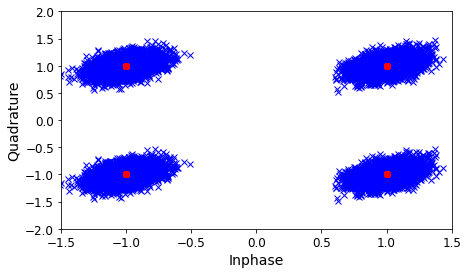

In [220]:
# Generater scatter plots of outputs
plt.figure(figsize=(pwidth,pheight))

plt.plot(ampl1_finali,ampl1_finalq+1,'bx',ampl1,np.zeros((len(ampl1),))+1,'ro')
plt.plot(ampl1_finali,ampl1_finalq-1,'bx',ampl1,np.zeros((len(ampl1),))-1,'ro')
plt.xlim([-1.5,1.5])
plt.ylim([-2,2])
plt.xlabel('Inphase')
plt.ylabel('Quadrature')
plt.savefig('scat2ask.eps', format='eps')
plt.show()
